# 7. Application of unsupervised learning

## Imports

In [3]:
import os
from typing import List

import numpy as np
import pandas as pd
import scipy.sparse
import sklearn.cluster
import sklearn.feature_extraction.text
from tqdm import tqdm

## Dataset

### Presentation

The dataset chosen describes a 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service.
We downloaded a smaller one compared to the original version <a href="http://files.grouplens.org/datasets/movielens/">here</a>.

The information used are only the movies title, movies id, user ids and the rating (from 0.5 to 5) a user gave to a movie.
Note that an user did not necessarily rate all the move, is just like on platform like Netflix, users can rate the films thew saw.

### Goals

Make a system recommender that is, from the ratings of a user, we want to recommand a film that he would enjoy.

The method is quite simple, each user will represent a sample, user will be represented by the list of their favorties movies.
We are going to use kmeans to group users in cluster.
Therefore, to recommend a movie to a user, we will compute it's cluster, take a user from there, get his favorites movies and recommand one of them to our first user.

Simple

### Load data

In [15]:
DIR_DATA = "data/ml-latest-small/"

In [16]:
movies = pd.read_csv(os.path.join(DIR_DATA, "movies.csv"))
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [17]:
ratings = pd.read_csv(os.path.join(DIR_DATA, "ratings.csv"))
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


## Stats

In [18]:
ratings["rating"].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

## Clustering

### Create X which each sample represents the n favorite movie of a user

In [19]:
def get_fav_movies(user_id : int, n : int) -> List[int]:
    return ratings[ratings["userId"] == user_id].sort_values(by="rating", ascending=False).iloc[:n,:]["movieId"].values

# associate each movie with an index
movie_id_to_index = {movie_id : index for index, movie_id in enumerate(ratings["movieId"].unique())}

# get all the users
users = ratings["userId"].unique()

# get the favorites move of each user
fav_movie_all_users = [
    get_fav_movies(user_id, 100)
    for user_id in tqdm(users, total=users.shape[0])
]

100%|██████████| 610/610 [00:00<00:00, 2175.66it/s]


In [20]:
# just need to transform these list to a matrix
def fav_movies_to_X(fav_movies : List[List[int]]):
    X = np.zeros((len(fav_movies), len(movie_id_to_index)))
    for index, fav_movies in enumerate(fav_movies):
        for movie_id in fav_movies:
            X[index, movie_id_to_index[movie_id]] = 1

    return scipy.sparse.csr_matrix(X)

X = fav_movies_to_X(fav_movie_all_users)
X.shape

(610, 9724)

### Search best hyperparameters with the Elbow method 

100%|██████████| 19/19 [00:00<00:00, 55.22it/s]


<Axes: xlabel='k_values'>

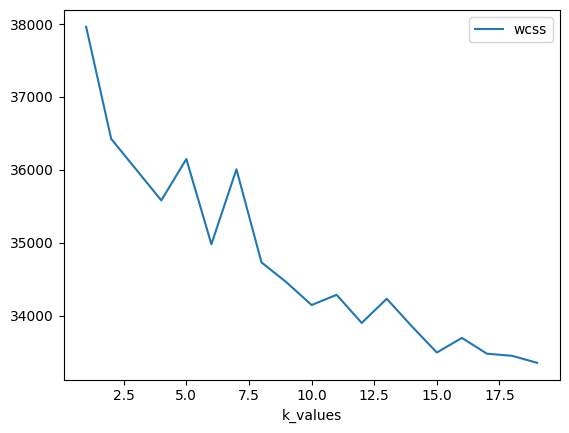

In [21]:
k_values = list(range(1, 20))
wcss = [
    sklearn.cluster.KMeans(n_clusters=k).fit(X).inertia_
    for k in tqdm(k_values)
]

pd.DataFrame({"wcss" : wcss, "k_values": k_values}).plot.line(x="k_values", y="wcss")

15 seems to be the best number of clusters

### Compute our model and fit with all the users 

In [28]:
kmeans  = sklearn.cluster.KMeans(n_clusters=15, n_init=10, init="k-means++")
clusters = kmeans.fit_predict(X.astype(np.int32))
clusters = pd.DataFrame({"userId": users,"cluster" : clusters})
clusters.groupby(by="cluster").count().rename(columns={"userId": "count"}).T

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,1,78,33,1,4,1,38,135,64,85,1,139,1,28,1


## Let's recommand movies

### Choose favorites movies

In [25]:
star_wars = movies[movies["title"].str.contains("Star Wars")]
harry_potter = movies[movies["title"].str.contains("Harry Potter")]
avengers = [
    "Avengers, The (2012)",
    "Avengers: Age of Ultron (2015)",
    "Avengers: Infinity War - Part I (2018)",
    "Avengers: Infinity War - Part II (2019)",
]
avengers = movies[movies["title"].isin(avengers)]

me_fav_movies = pd.concat([star_wars, harry_potter, avengers])
me_fav_movies

,movieId,title,genres
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
911,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
1979,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
3832,5378,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX
5896,33493,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi
6823,61160,Star Wars: The Clone Wars (2008),Action|Adventure|Animation|Sci-Fi
7367,79006,Empire of Dreams: The Story of the 'Star Wars'...,Documentary
8683,122886,Star Wars: Episode VII - The Force Awakens (2015),Action|Adventure|Fantasy|Sci-Fi|IMAX
8908,135216,The Star Wars Holiday Special (1978),Adventure|Children|Comedy|Sci-Fi


### Do all the steps

In [31]:
me_fav_movies = me_fav_movies["movieId"].to_numpy()

# predict my cluster
cluster = kmeans.predict(fav_movies_to_X([me_fav_movies]))[0]

# get a person from the same cluster
user_id = clusters[clusters["cluster"] == cluster].iloc[0]["userId"]

# get its favorites movies
fav_movies = movies[movies["movieId"].isin(get_fav_movies(user_id, 10))]

# filter by those already seen
fav_movies = fav_movies[~fav_movies["movieId"].isin(me_fav_movies)]

# here is the recommendions !!!!
fav_movies["title"]

656                  Escape from L.A. (1996)
2141                         Saturn 3 (1980)
2765    Road Warrior, The (Mad Max 2) (1981)
3335       The Lair of the White Worm (1988)
3734                        Hangar 18 (1980)
4045         Galaxy of Terror (Quest) (1981)
4122                          Android (1982)
4595              Alien Contamination (1980)
5080                  Death Race 2000 (1975)
7114                          Troll 2 (1990)
Name: title, dtype: object

## Conclusion

This is a quite easy way to build a recommend system.
The clusters are well balanced without counting the clusters where there is just one outsider.